## Data Preparation


### 1. Download the dataset 

In this task, we will use part of dataset of the Fruits and Vegetables from Kaggle : https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition

In [1]:
import os
dataset_zip_file = "fruits.zip"
if not os.path.exists(dataset_zip_file):
  import urllib.request
  urllib.request.urlretrieve("https://seafile.ifi.uzh.ch/f/72e1d9c4ef20420eb1d9/?dl=1", dataset_zip_file)
  print ("Downloaded datafile", dataset_zip_file)
  import zipfile
  zipfile.ZipFile(dataset_zip_file).extractall()

Downloaded datafile fruits.zip


### 2. Data transformation 
Since we will use networks pre-trained on ImageNet, we need to perform the exact same transform as used for ImageNet testing.
We need to instantiate a proper `torchvision.transform` instance to create the same input structure as used for training our network.  

We need to combine 4 transforms, which can be compiled from the PyTorch website: https://pytorch.org/vision/stable/models.html

1. resize the image such that the shorter side has size 256.
2. take the center crop of size $224\times224$ from the image.
3. convert the image into a tensor (including pixel values scaling)
4. normalize the pixel values with mean $(0.485, 0.456, 0.406)$ and standard deviation $(0.229, 0.224, 0.225)



In [4]:
import torch
import torchvision

imagenet_transform = torchvision.transforms.Compose((
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
))

### 3. Dataset Load 
We here use the `torchvision.datasets.ImageFolder` dataset interface for processing images. https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html

You can use its documented `is_valid_file` parameter to distinguish between training and test set.
The training files are all called `gallery.jpg` while test files are called `probe.jpg`.


In [6]:
trainset = torchvision.datasets.ImageFolder(
  root = "fruits",
  transform = imagenet_transform,
  is_valid_file= lambda x: os.path.basename(x) == "gallery.jpg"
)

testset = torchvision.datasets.ImageFolder(
  root = "fruits",
  transform = imagenet_transform,
  is_valid_file= lambda x: os.path.basename(x) == "probe.jpg"

)

## Instantiate Pre-trained Network

Instantiate a pre-trained network of type ResNet-18. 
Modify the network such that we extract the deep features from before the last fully-connected layer of the network.
For your reference, the implementation of the `forward` function of ResNet networks (including ResNet-18) can be found here: https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py#L264

You can also check if other networks perform better, especially deeper ResNet topologies.
Be aware that our strategy to remove the last fully-connected layer might not work in other network topologies, only in residual networks.

Please Note: while we modify the `forward` function, we will still use the `__call__` function to extract our features.

In [5]:
# instantiate pre-trained resnet 18 network
network = torchvision.models.resnet18(pretrained=True)
network.eval()

# make sure that deep features can be etxracted from the network
network.fc = torch.nn.Identity() # overwrite last layer to identity

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

## Extract Feature

- Implement a function that extracts all features for a given dataset.
- Store the results in a dictionary: `target : feature`.
- Extract the features for the training and the test set.

In [7]:
def extract(network, dataset):
  features = {}
  with torch.no_grad():
    for x,t in dataset:
      features[t] = network(x.unsqueeze(0))
  return features 

In [8]:
train_features = extract(network, trainset)
test_features = extract(network, testset) 

## Similarity Computation 

Compute the cosine similarity between all samples in training and test set
https://pytorch.org/docs/stable/generated/torch.nn.functional.cosine_similarity.html


In [9]:
keys = train_features.keys()
classes = len(keys)
similarities = torch.empty((classes,classes))

with torch.no_grad():
  for o, c1 in enumerate(keys):
    for t, c2 in enumerate(keys):
      similarities[t,o] = torch.nn.functional.cosine_similarity(train_features[c1], test_features[c2], dim=1).item()

## Visualize Similarity

Text(0, 0.5, 'Test class')

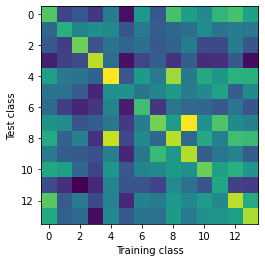

In [18]:
from matplotlib import pyplot

pyplot.imshow(similarities)
pyplot.xlabel("Training class")
pyplot.ylabel("Test class")

## Classification Accuracy

Compute the classification accuracy by checking if the class of highest similarity for a test sample is the correct class.

In [20]:
indexes = [torch.argmax(similarities[t]).item() for t in range(classes)] ## ?
correct = [indexes[t] == t for t in range(classes)]
accuracy = sum(correct) / classes

print("Accuracy is", accuracy)
                      

Accuracy is 0.7857142857142857


## Find Misclassified Images and Classes


Find the test samples that are incorrectly classified. 
Get the class names (not only indexes) and write the names of the test sample class as well as the class that it was classified as.

What are the two most dissimilar classes?

In [22]:
names = sorted(os.listdir("fruits"))

for t in range(classes):
  if not correct[t]:
    print("Probe image of class", t, "which is", names[t], "was classified as", indexes[t], names[indexes[t]])

Probe image of class 5 which is ginger was classified as 11 potato
Probe image of class 7 which is lemon was classified as 9 orange
Probe image of class 8 which is onion was classified as 4 garlic


In [24]:
import numpy as np

t, o = np.unravel_index(np.argmin(similarities), similarities.shape)
print(t, names[t], "is most dissimilar to", o, names[o])

11 potato is most dissimilar to 2 carrot
